In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

IMG_PATH_TRAIN = IMG_PATH

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 300
hyperparams.BATCH_SIZE = 16

hyperparams.NUM_CHANNELS = 32
hyperparams.NUM_RES_BLOCKS = 5

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0001_0010"
MODEL_NAME = "0001_0010-64-resnet-xxh"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.1418
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.2947

from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import ResnetBatchE as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9665671242984764513
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1749606400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10624082250606547822
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT)

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/
Noisy files:19657
Nitid files:19657
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/validation/
Noisy files:4900
Nitid files:4900


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/300
1229/1229 [==============================] - 188s 142ms/step - loss: 0.1431 - val_loss: 0.0614
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_01-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/300
1229/1229 [==============================] - 173s 141ms/step - loss: 0.0570 - val_loss: 0.0551
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_02-0.06\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0513 - val_loss: 0.0492
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_03-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0487 - val_loss: 0.0471
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_04-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0471 - val_loss: 0.0460
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_05-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0459 - val_loss: 0.0459
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_06-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0450 - val_loss: 0.0452
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_07-0.05\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0442 - val_loss: 0.0447
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_08-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0435 - val_loss: 0.0428
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_09-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0427 - val_loss: 0.0414
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_10-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0419 - val_loss: 0.0417
Epoch 12/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0412 - val_loss: 0.0415
Epoch 13/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0405 - val_loss: 0.0408
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_13-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0400 - val_loss: 0.0383
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_14-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0396 - val_loss: 0.0398
Epoch 16/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0392 - val_loss: 0.0386
Epoch 17/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0389 - val_loss: 0.0405
Epoch 18/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0385 - val_loss: 0.0368
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_18-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0381 - val_loss: 0.0377
Epoch 20/300
1229/1229 [==============================] - 213s 174ms/step - loss: 0.0381 - val_loss: 0.0389
Epoch 21/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0377 - val_loss: 0.0433
Epoch 22/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0374 - val_loss: 0.0365
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_22-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0371 - val_loss: 0.0368
Epoch 24/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0368 - val_loss: 0.0382
Epoch 25/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0366 - val_loss: 0.0362
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_25-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 26/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0365 - val_loss: 0.0364
Epoch 27/300
1229/1229 [==============================] - 215s 175ms/step - loss: 0.0363 - val_loss: 0.0378
Epoch 28/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0361 - val_loss: 0.0350
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_28-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 29/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0361 - val_loss: 0.0366
Epoch 30/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0358 - val_loss: 0.0379
Epoch 31/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0355 - val_loss: 0.0356
Epoch 32/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0354 - val_loss: 0.0346
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_32-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 33/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0353 - val_loss: 0.0394
Epoch 34/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0353 - val_loss: 0.0388
Epoch 35/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0351 - val_loss: 0.0376
Epoch 36/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0348 - val_loss: 0.0372
Epoch 37/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0348 - val_loss: 0.0400
Epoch 38/300
1229/1229 [==============================] - 213s 174ms/step - loss: 0.0346 - val_loss: 0.0339
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_38-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 39/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0345 - val_loss: 0.0361
Epoch 40/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0343 - val_loss: 0.0397
Epoch 41/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0342 - val_loss: 0.0416
Epoch 42/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0341 - val_loss: 0.0341
Epoch 43/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0340 - val_loss: 0.0453
Epoch 44/300
1229/1229 [==============================] - 213s 174ms/step - loss: 0.0338 - val_loss: 0.0359
Epoch 45/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0339 - val_loss: 0.0367
Epoch 46/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0338 - val_loss: 0.0379
Epoch 47/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0337 - val_loss: 0.0336
INFO:tensorflow:Assets writt

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 48/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0336 - val_loss: 0.0419
Epoch 49/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0337 - val_loss: 0.0376
Epoch 50/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0336 - val_loss: 0.0391
Epoch 51/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0333 - val_loss: 0.0347
Epoch 52/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0333 - val_loss: 0.0348
Epoch 53/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0333 - val_loss: 0.0355
Epoch 54/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0333 - val_loss: 0.0343
Epoch 55/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0331 - val_loss: 0.0393
Epoch 56/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0330 - val_loss: 0.0348
Epoch 57/300
1229/1229 [====

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 61/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0327 - val_loss: 0.0346
Epoch 62/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0327 - val_loss: 0.0354
Epoch 63/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0326 - val_loss: 0.0417
Epoch 64/300
1229/1229 [==============================] - 215s 175ms/step - loss: 0.0326 - val_loss: 0.0369
Epoch 65/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0325 - val_loss: 0.0353
Epoch 66/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0326 - val_loss: 0.0355
Epoch 67/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0323 - val_loss: 0.0381
Epoch 68/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0322 - val_loss: 0.0384
Epoch 69/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0322 - val_loss: 0.0343
Epoch 70/300
1229/1229 [====

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 73/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0321 - val_loss: 0.0366
Epoch 74/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0321 - val_loss: 0.0349
Epoch 75/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0321 - val_loss: 0.0360
Epoch 76/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0320 - val_loss: 0.0334
Epoch 77/300
1229/1229 [==============================] - 213s 174ms/step - loss: 0.0319 - val_loss: 0.0392
Epoch 78/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0319 - val_loss: 0.0357
Epoch 79/300
1229/1229 [==============================] - 213s 174ms/step - loss: 0.0318 - val_loss: 0.0326
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_79-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 80/300
1229/1229 [==============================] - 215s 174ms/step - loss: 0.0317 - val_loss: 0.0349
Epoch 81/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0317 - val_loss: 0.0335
Epoch 82/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0315 - val_loss: 0.0405
Epoch 83/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0316 - val_loss: 0.0316
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh_checkpoint__weights_83-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 84/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0316 - val_loss: 0.0364
Epoch 85/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0317 - val_loss: 0.0346
Epoch 86/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0314 - val_loss: 0.0353
Epoch 87/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0314 - val_loss: 0.0368
Epoch 88/300
1229/1229 [==============================] - 215s 175ms/step - loss: 0.0313 - val_loss: 0.0322
Epoch 89/300
1229/1229 [==============================] - 213s 174ms/step - loss: 0.0313 - val_loss: 0.0327
Epoch 90/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0313 - val_loss: 0.0386
Epoch 91/300
1229/1229 [==============================] - 214s 174ms/step - loss: 0.0313 - val_loss: 0.0367
Epoch 92/300
1229/1229 [==============================] - 215s 175ms/step - loss: 0.0311 - val_loss: 0.0336
Epoch 93/300
1229/1229 [====

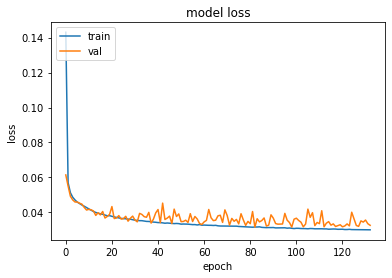

Best Epoch:83


In [8]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0001_0010-64-resnet-xxh\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =4900
Best RMSENZ  =4385 (0.89)
Best MAENZ   =4438 (0.91)
Best PSNR    =4385 (0.89)
Best Accuracy=4534 (0.93)
RMSE-NZ  Pred=0.0422  Noisy=0.1031
MAE-NZ   Pred=0.0321  Noisy=0.0937
PSNR     Pred=15.3 dB Noisy=8.8 dB
Accuracy Pred=0.32    Noisy=0.12
SSM      Pred=0.75    Noisy=0.42
HOG MSE  Pred=0.08    Noisy=0.08


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test/
Noisy files:17
Nitid files:17
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_00_2_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_00_2_nitid_idx008.tif


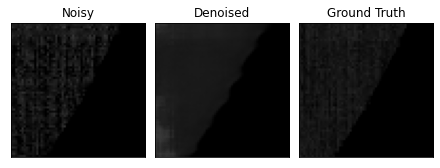

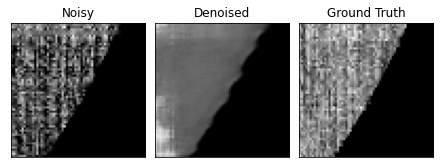

RMSE-NZ  Pred=0.0314  Noisy=0.0423 BEST
MAE-NZ   Pred=0.0183  Noisy=0.0298 BEST
PSNR     Pred=13.7 dB Noisy=11.1 dB BEST
Accuracy Pred=0.53    Noisy=0.36 BEST
SSM      Pred=0.78    Noisy=0.63
HOG MSE  Pred=0.08    Noisy=0.01
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_01_5_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0025_06_01_5_nitid_idx017.tif


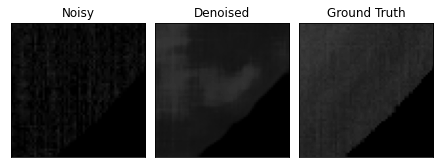

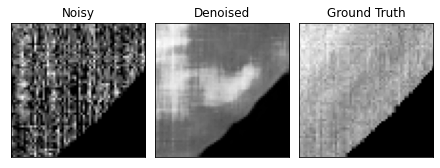

RMSE-NZ  Pred=0.0478  Noisy=0.1180 BEST
MAE-NZ   Pred=0.0379  Noisy=0.1096 BEST
PSNR     Pred=13.9 dB Noisy=6.1 dB BEST
Accuracy Pred=0.25    Noisy=0.07 BEST
SSM      Pred=0.77    Noisy=0.46
HOG MSE  Pred=0.02    Noisy=0.09
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_02_04_9_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_02_04_9_nitid_idx146.tif


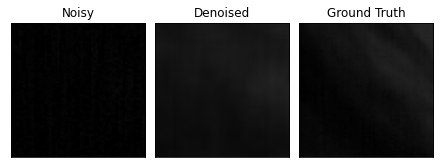

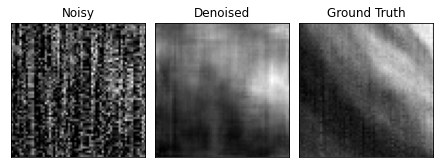

RMSE-NZ  Pred=0.0283  Noisy=0.0587 BEST
MAE-NZ   Pred=0.0238  Noisy=0.0477 BEST
PSNR     Pred=15.0 dB Noisy=8.6 dB BEST
Accuracy Pred=0.21    Noisy=0.13 BEST
SSM      Pred=0.79    Noisy=0.24
HOG MSE  Pred=0.06    Noisy=0.07
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_11_nitid_idx134.tif


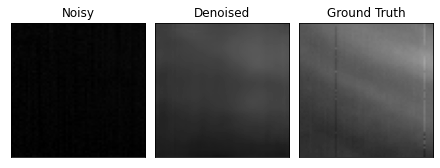

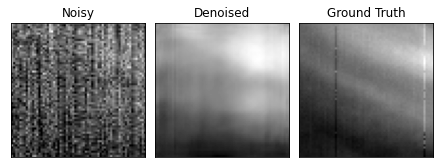

RMSE-NZ  Pred=0.1238  Noisy=0.3357 BEST
MAE-NZ   Pred=0.1157  Noisy=0.3214 BEST
PSNR     Pred=14.2 dB Noisy=5.6 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.78    Noisy=0.15
HOG MSE  Pred=0.10    Noisy=0.11
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_13_nitid_idx134.tif


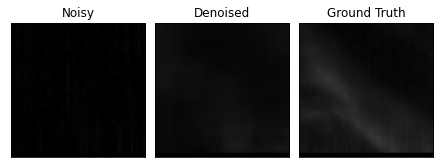

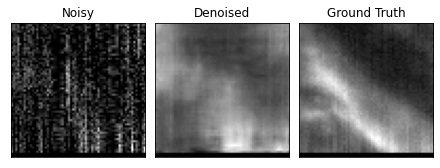

RMSE-NZ  Pred=0.0499  Noisy=0.0869 BEST
MAE-NZ   Pred=0.0373  Noisy=0.0747 BEST
PSNR     Pred=12.5 dB Noisy=7.7 dB BEST
Accuracy Pred=0.30    Noisy=0.01 BEST
SSM      Pred=0.78    Noisy=0.33
HOG MSE  Pred=0.05    Noisy=0.11
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_3_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_3_nitid_idx134.tif


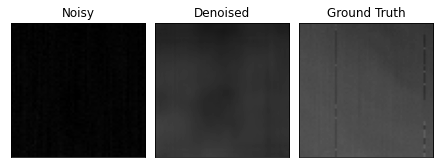

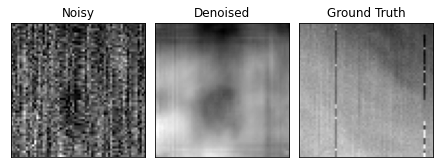

RMSE-NZ  Pred=0.1007  Noisy=0.2662 BEST
MAE-NZ   Pred=0.0978  Noisy=0.2643 BEST
PSNR     Pred=11.5 dB Noisy=3.1 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.79    Noisy=0.16
HOG MSE  Pred=0.08    Noisy=0.10
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0330_03_03_5_nitid_idx134.tif


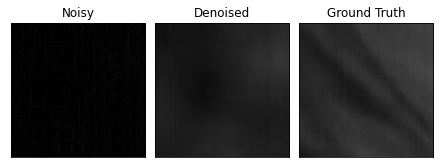

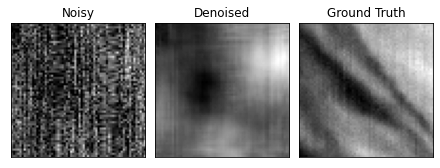

RMSE-NZ  Pred=0.0688  Noisy=0.1729 BEST
MAE-NZ   Pred=0.0641  Noisy=0.1686 BEST
PSNR     Pred=12.4 dB Noisy=4.4 dB BEST
Accuracy Pred=0.01    Noisy=0.00 BEST
SSM      Pred=0.76    Noisy=0.19
HOG MSE  Pred=0.08    Noisy=0.15
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0338_04_00_10_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0338_04_00_10_nitid_idx008.tif


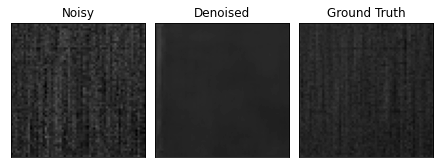

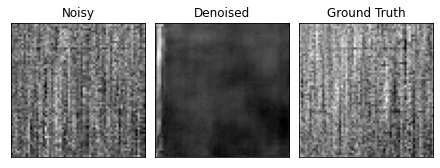

RMSE-NZ  Pred=0.0290  Noisy=0.0606 BEST
MAE-NZ   Pred=0.0226  Noisy=0.0478 BEST
PSNR     Pred=18.4 dB Noisy=12.0 dB BEST
Accuracy Pred=0.28    Noisy=0.15 BEST
SSM      Pred=0.59    Noisy=0.30
HOG MSE  Pred=0.13    Noisy=0.03
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_04_03_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_04_03_5_nitid_idx134.tif


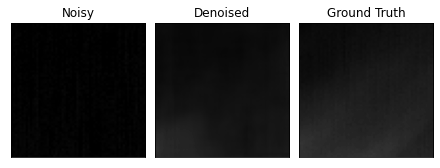

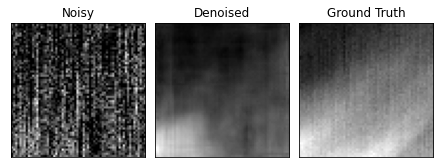

RMSE-NZ  Pred=0.0434  Noisy=0.1061 BEST
MAE-NZ   Pred=0.0375  Noisy=0.0983 BEST
PSNR     Pred=13.5 dB Noisy=5.8 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.85    Noisy=0.25
HOG MSE  Pred=0.09    Noisy=0.04
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_05_03_8_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0339_05_03_8_nitid_idx134.tif


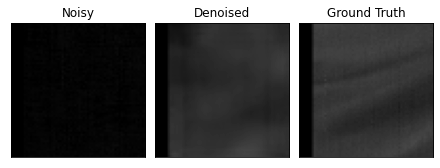

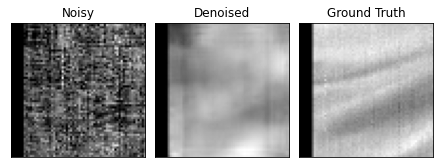

RMSE-NZ  Pred=0.0513  Noisy=0.1969 BEST
MAE-NZ   Pred=0.0373  Noisy=0.1941 BEST
PSNR     Pred=14.9 dB Noisy=3.2 dB BEST
Accuracy Pred=0.25    Noisy=0.00 BEST
SSM      Pred=0.86    Noisy=0.15
HOG MSE  Pred=0.03    Noisy=0.24
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0353_09_00_15_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0353_09_00_15_nitid_idx008.tif


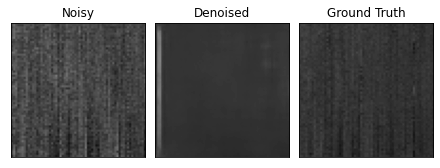

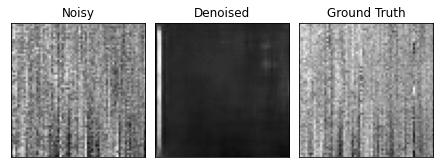

RMSE-NZ  Pred=0.0482  Noisy=0.0925 BEST
MAE-NZ   Pred=0.0284  Noisy=0.0774 BEST
PSNR     Pred=15.8 dB Noisy=10.1 dB BEST
Accuracy Pred=0.29    Noisy=0.06 BEST
SSM      Pred=0.55    Noisy=0.28
HOG MSE  Pred=0.11    Noisy=0.03
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_00_5_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_00_5_nitid_idx008.tif


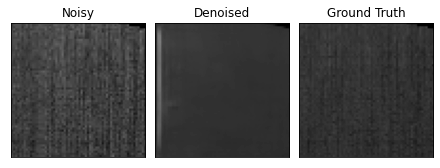

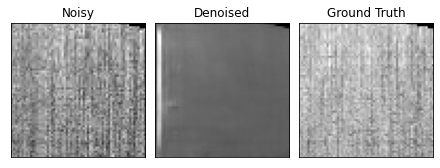

RMSE-NZ  Pred=0.0426  Noisy=0.0770 BEST
MAE-NZ   Pred=0.0247  Noisy=0.0644 BEST
PSNR     Pred=16.4 dB Noisy=11.2 dB BEST
Accuracy Pred=0.32    Noisy=0.08 BEST
SSM      Pred=0.62    Noisy=0.32
HOG MSE  Pred=0.22    Noisy=0.03
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_01_7_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0357_01_01_7_nitid_idx017.tif


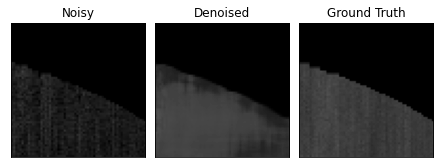

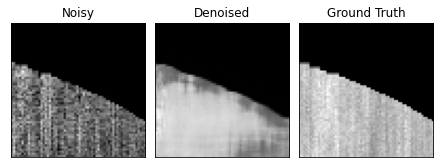

RMSE-NZ  Pred=0.0379  Noisy=0.1235 BEST
MAE-NZ   Pred=0.0220  Noisy=0.1063 BEST
PSNR     Pred=18.4 dB Noisy=8.2 dB BEST
Accuracy Pred=0.54    Noisy=0.19 BEST
SSM      Pred=0.81    Noisy=0.67
HOG MSE  Pred=0.08    Noisy=0.01
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0618_03_01_9_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0618_03_01_9_nitid_idx017.tif


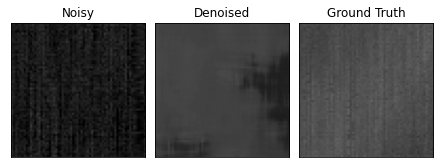

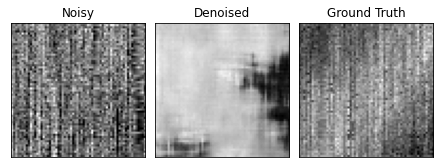

RMSE-NZ  Pred=0.0845  Noisy=0.2174 BEST
MAE-NZ   Pred=0.0698  Noisy=0.2121 BEST
PSNR     Pred=13.4 dB Noisy=5.2 dB BEST
Accuracy Pred=0.07    Noisy=0.00 BEST
SSM      Pred=0.61    Noisy=0.28
HOG MSE  Pred=0.03    Noisy=0.05
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_00_04_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_00_04_11_nitid_idx146.tif


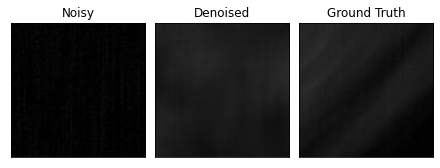

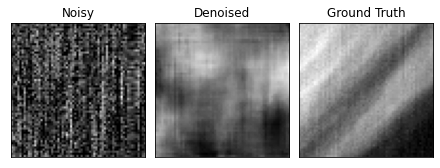

RMSE-NZ  Pred=0.0381  Noisy=0.0873 BEST
MAE-NZ   Pred=0.0314  Noisy=0.0780 BEST
PSNR     Pred=13.4 dB Noisy=6.2 dB BEST
Accuracy Pred=0.19    Noisy=0.06 BEST
SSM      Pred=0.75    Noisy=0.22
HOG MSE  Pred=0.12    Noisy=0.17
******************************************************
Index:15
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_01_00_2_noisy_idx006.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0720_01_00_2_nitid_idx008.tif


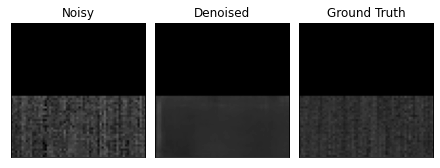

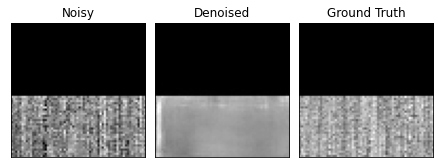

RMSE-NZ  Pred=0.0249  Noisy=0.0789 BEST
MAE-NZ   Pred=0.0140  Noisy=0.0631 BEST
PSNR     Pred=21.3 dB Noisy=11.2 dB BEST
Accuracy Pred=0.62    Noisy=0.09 BEST
SSM      Pred=0.78    Noisy=0.64
HOG MSE  Pred=0.22    Noisy=0.02
******************************************************
Index:16
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0726_03_01_15_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0001_0010/test\VI0726_03_01_15_nitid_idx017.tif


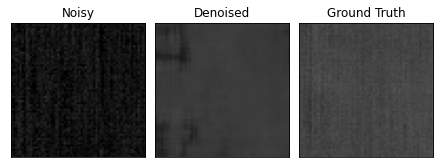

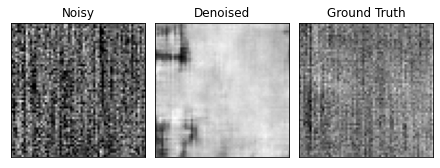

RMSE-NZ  Pred=0.0549  Noisy=0.2053 BEST
MAE-NZ   Pred=0.0476  Noisy=0.2012 BEST
PSNR     Pred=16.2 dB Noisy=4.7 dB BEST
Accuracy Pred=0.05    Noisy=0.00 BEST
SSM      Pred=0.70    Noisy=0.24
HOG MSE  Pred=0.03    Noisy=0.05
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )